In [ ]:
# To installing to mac, use:
# conda-forge: conda install -c conda-forge fbprophet

In [32]:
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

In [9]:
df.tail()

,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [27]:
(2904-730-365)/180

10.05

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. This figure illustrates a simulated historical forecast on the Peyton Manning dataset, where the model was fit to a initial history of 5 years, and a forecast was made on a one year horizon.

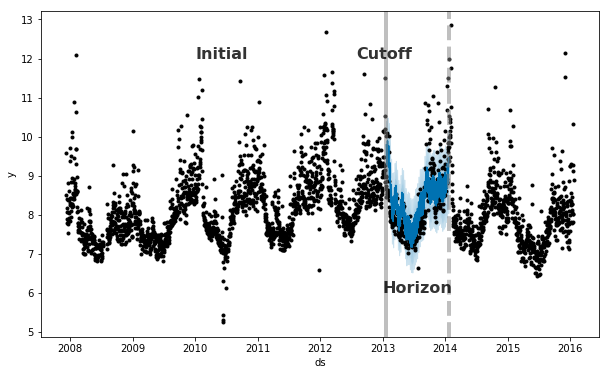

In [6]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(
    m, '365 days', initial='1825 days', period='365 days')
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
ax.text(x=pd.to_datetime('2010-01-01'),y=12, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2012-08-01'),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2013-01-01'),y=6, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);

[The Prophet paper](https://peerj.com/preprints/3190.pdf) gives further description of simulated historical forecasts.

This cross validation procedure can be done automatically for a range of historical cutoffs using the `cross_validation` function. We specify the forecast horizon (`horizon`), and then optionally the size of the initial training period (`initial`) and the spacing between cutoff dates (`period`). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

The output of `cross_validation` is a dataframe with the true values `y` and the out-of-sample forecast values `yhat`, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between `cutoff` and `cutoff + horizon`. This dataframe can then be used to compute error measures of `yhat` vs. `y`.

Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. On this 8 year time series, this corresponds to 11 total forecasts.

In [7]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.960441,8.413034,9.438598,8.242493,2010-02-15
1,2010-02-17,8.726966,8.213176,9.207769,8.008033,2010-02-15
2,2010-02-18,8.610869,8.115672,9.101070,8.045268,2010-02-15
3,2010-02-19,8.532795,8.047087,9.051873,7.928766,2010-02-15
4,2010-02-20,8.274904,7.806038,8.774270,7.745003,2010-02-15


In [18]:
df.tail()

,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [19]:
df_cv[365:365*2].head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
365,2010-08-23,7.973096,7.436909,8.514572,8.440528,2010-08-14
366,2010-08-24,7.806208,7.291840,8.366625,8.313852,2010-08-14
367,2010-08-25,7.663370,7.123882,8.156921,8.080856,2010-08-14
368,2010-08-26,7.632947,7.112955,8.183338,8.185907,2010-08-14
369,2010-08-27,7.638375,7.102177,8.145115,8.856803,2010-08-14


In [17]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
3983,2016-01-16,8.580395,7.865414,9.462696,7.817223,2015-01-20
3984,2016-01-17,8.975041,8.267482,9.702261,9.273878,2015-01-20
3985,2016-01-18,9.281189,8.575057,10.110297,10.333775,2015-01-20
3986,2016-01-19,9.064340,8.350171,9.814960,9.125871,2015-01-20
3987,2016-01-20,8.900521,8.227770,9.685436,8.891374,2015-01-20


In R, the argument `units` must be a type accepted by `as.difftime`, which is weeks or shorter. In Python, the string for `initial`, `period`, and `horizon` should be in the format used by Pandas Timedelta, which accepts units of days or shorter.

The `performance_metrics` utility can be used to compute some useful statistics of the prediction performance (`yhat`, `yhat_lower`, and `yhat_upper` compared to `y`), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), and coverage of the `yhat_lower` and `yhat_upper` estimates. These are computed on a rolling window of the predictions in `df_cv` after sorting by horizon (`ds` minus `cutoff`). By default 10% of the predictions will be included in each window, but this can be changed with the `rolling_window` argument.

In [31]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,37 days,0.495161,0.703677,0.505237,0.058536,0.684102
1,38 days,0.500957,0.707783,0.510231,0.059114,0.684102
2,39 days,0.523235,0.723350,0.516340,0.059715,0.682732
3,40 days,0.530583,0.728411,0.519241,0.060026,0.681361
4,41 days,0.538145,0.733584,0.520267,0.060108,0.688899


In [29]:
df_p

,horizon,mse,rmse,mae,mape,coverage
0,1 days,0.986805,0.993380,0.605805,0.061766,0.545455
1,2 days,0.408060,0.638796,0.519759,0.058647,0.545455
2,3 days,0.469612,0.685282,0.614648,0.072345,0.454545
3,4 days,0.447970,0.669306,0.561151,0.066229,0.363636
4,5 days,0.521913,0.722435,0.620452,0.071588,0.363636
5,6 days,0.502098,0.708588,0.605482,0.069890,0.545455
6,7 days,0.459055,0.677536,0.571658,0.066800,0.636364
7,8 days,0.740268,0.860388,0.538786,0.056824,0.600000
8,9 days,1.182770,1.087552,0.647965,0.065545,0.636364
9,10 days,0.471487,0.686649,0.605135,0.070284,0.636364


Cross validation performance metrics can be visualized with `plot_cross_validation_metric`, here shown for MAPE. Dots show the absolute percent error for each prediction in `df_cv`. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 5% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out.

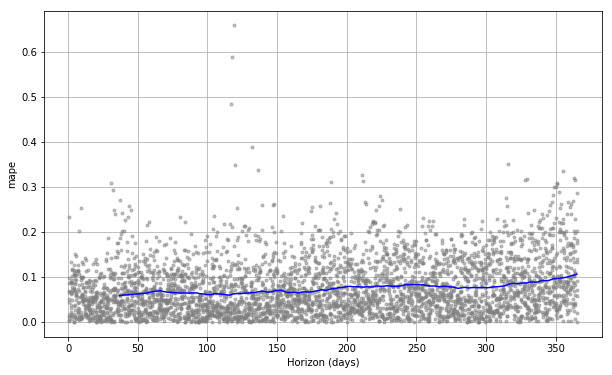

In [30]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

The size of the rolling window in the figure can be changed with the optional argument `rolling_window`, which specifies the proportion of forecasts to use in each rolling window. The default is 0.1, corresponding to 10% of rows from `df_cv` included in each window; increasing this will lead to a smoother average curve in the figure.

The `initial` period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.